### Image Classification

Following are the steps to use this notebook:
1. Download pre-trained classification model (e.g., MobileNetV2) by using 01_model_downloader.ipynb. 

2. Check its corresponding documentation to get all the required preprocessing details. These preprocessing values will going to be used to prepare input image (or, blob). 

3. If you model is already in IR format (.bin and .xml) then it is most likely that a preprocessing layer has been added before the first input layer. In that case, look into the XML to verify it or look into the documentation. 

For example:

MobileNetV2 (used in this notebook): https://docs.openvinotoolkit.org/latest/omz_models_public_mobilenet_v2_mobilenet_v2.html 

-> In summary, details are:
* Model is trained using Caffe (hence, trained model is in .caffe and .prototxt format)
* Input image size - 224 x 224 
* Channel order - BGR
* Mean to be subtracted - [103.94,116.78,123.68] 
* Scale factor - 58.8235294117647
* Output size - 1x1000 (ImageNet classes)


SqueezeNet 1.0: 
https://docs.openvinotoolkit.org/latest/omz_models_public_squeezenet1_0_squeezenet1_0.html

-> In summary, these values are required:
* Input size - (227, 227)
* Channel order - BGR 
* Mean values to be subtracted (Preprocessing) - [104,117,123]
* Output size - 1x1000 (ImageNet classes)

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass

%matplotlib inline

#### Define parameters 

In [3]:
# Parameters
IMG_FPATH = "./images/panda.jpg" #kitti_img.png face_img.jpg

MODEL_TYPE = "mobilenetv2" # or, mobilenetv2 or squeezenetv1
MODEL_FPATH = "./models/public/mobilenet-v2/mobilenet-v2.caffemodel" 
ARCH_FPATH = "./models/public/mobilenet-v2/mobilenet-v2.prototxt" # model's architecture or topology

# since both models are trained on ImageNet dataset, therefore, load the class names
IMGNET_LABEL_FPATH = "./synset_words.txt" 

#### Extract class names of ImageNet dataset

In [4]:
# Extract class labels/names from synset words file
rows = open(IMGNET_LABEL_FPATH).read().strip().split("\n")
classes = [r[r.find(" ") + 1:].split(",")[0] for r in rows]
print(classes[:10])

['tench', 'goldfish', 'great white shark', 'tiger shark', 'hammerhead', 'electric ray', 'stingray', 'cock', 'hen', 'ostrich']


#### Model configuration for the input image 

In [5]:
@dataclass
class ModelConfig:
    scalefactor: float = 1.0
    size: tuple = (224, 224)
    mean: tuple = (0, 0, 0)
    swapRB: bool = False
    crop: bool = False
    ddepth: int = cv2.CV_32F

# Extend this dict for the new model type
configs = {'squeezenet1.0': vars(ModelConfig(scalefactor=1.0,
                                             size=(227, 227),
                                             mean=(104, 117, 123))), 
           'mobilenetv2': vars(ModelConfig(scalefactor=1/58.8235294117647,
                                           size=(224, 224),
                                           mean=(103.94,116.78,123.68)))}

print(configs[MODEL_TYPE])

{'scalefactor': 0.017, 'size': (224, 224), 'mean': (103.94, 116.78, 123.68), 'swapRB': False, 'crop': False, 'ddepth': 5}


#### Load image and create a blob

In [6]:
# Load image and prepare a blob which is going to be input to the model
img = cv2.imread(IMG_FPATH)
if img is None:
    raise Exception(f'Image not found with the path provided: {IMG_FPATH}')
    
blob = cv2.dnn.blobFromImage(img,
                             scalefactor=configs[MODEL_TYPE]['scalefactor'],
                             size=configs[MODEL_TYPE]['size'],
                             mean=configs[MODEL_TYPE]['mean'],
                             swapRB=configs[MODEL_TYPE]['swapRB'],
                             crop=configs[MODEL_TYPE]['crop'],
                             ddepth=configs[MODEL_TYPE]['ddepth'])

print(blob.shape) # Blob returns in NCHW format

(1, 3, 224, 224)


#### Load model and run inference

In [7]:
# Load model
net = cv2.dnn.readNet(ARCH_FPATH, MODEL_FPATH) # or, cv2.dnn.readNetFromCaffe(ARCH_FPATH, MODEL_FPATH)

# Specify target device
net.setPreferableBackend(cv2.dnn.DNN_BACKEND_INFERENCE_ENGINE)
net.setPreferableTarget(cv2.dnn.DNN_TARGET_CPU)

# Run inference
net.setInput(blob)
preds = net.forward()

#### Show results

In [8]:
# Flatten them in an array
preds = preds.flatten() 

# Sort the array in descending order and pick top 5 results
pred_class_ids = np.argsort(preds)[::-1]
pred_class_ids = pred_class_ids[:5]
pred_confs = preds[pred_class_ids]

for class_id, pred_conf in zip(pred_class_ids, pred_confs):
    print(f"label: {classes[class_id]} and pred prob: {pred_conf:.3f}")

label: giant panda and pred prob: 1.000
label: soccer ball and pred prob: 0.000
label: teddy and pred prob: 0.000
label: gibbon and pred prob: 0.000
label: American black bear and pred prob: 0.000


#### Display on image

In [9]:
def show_img(img):
    dpi = 80
    height, width, _ = img.shape
    figsize = width / float(dpi), height / float(dpi)
    
    fig = plt.figure(figsize=figsize)
    plt.axis('off')
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.show()

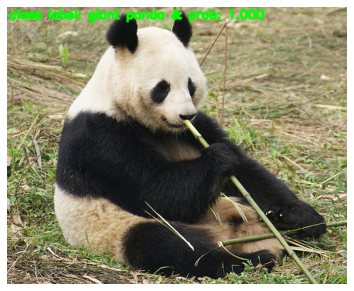

In [10]:
text = f"class label: {classes[pred_class_ids[0]]} & prob: {pred_confs[0]:.3f}"
img = cv2.putText(img, text, (3, 18), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2, cv2.LINE_AA)

show_img(img)